## Python Data fitting with various functions - HW 12
Due Monday Dec 1, 2025



Dowload the data "miniDR17.fits" from the TCU Online Week 14:<br>
<i>NOTE: it is a large-ish file and may take a while.</i>

**However, this is a small version of the full science data file (4 GB) which can be found at:**<br>
https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits


My example below will show how to remove Identified bad data, 
however data that are just bad in one quantity may remain

_Use masking to remove any remaining bad values (typically 9999 or -9999 in this file_ , <b>but check!!!! If you are not sure, ask!!!</b>). 

In [117]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits 
import scipy.optimize as opt

# POTENTIAL FITTING FUNCTIONS
def linear(x,m,b):
    return m*x+b

def poly2(x,a,b,c):
    return a*(x**2)+(b*x)+c

def poly3(x,a,b,c,d):
    return (a*(x**3))+(b*(x**2))+(c*x)+d

def cosfit (x,a,b,c,d):
    return a*np.cos(b*x + c) + d

def exponential(x,a,b,c,d):
    return a*np.exp(b*x + c) + d


# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))


# Monte Carlo-version of 3 parameter Curve Fit that can use BOTH x and Y errors
def mcFit3(func, x, y, x_err=0.1, y_err=0.1,p0=[1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
    return (np.median(paramA),np.median(paramB),np.median(paramC))

# Monte Carlo-version of 4 parameter Curve Fit that can use BOTH x and Y errors
def mcFit4(func, x, y, x_err=0.1, y_err=0.1, p0=[1,1,1,1]):
    paramA = list()
    paramB = list()
    paramC = list()
    paramD = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0, maxfev = 1000)
        paramA.append(popt[0])
        paramB.append(popt[1])
        paramC.append(popt[2])
        paramD.append(popt[3])
    return (np.median(paramA),np.median(paramB),np.median(paramC),np.median(paramD))


In [3]:
# READ IN FITS FILES
star_hdus = fits.open('miniDR17.fits')
star = star_hdus[1].data
print(star_hdus[1].columns)
star_hdus.close()

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'TEFF'; format = 'E'
    name = 'TEFF_ERR'; format = 'E'
    name = 'LOGG'; format = 'E'
    name = 'LOGG_ERR'; format = 'E'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SNR'; format = 'E'
    name = 'VHELIO_AVG'; format = 'E'
    name = 'VERR'; format = 'E'
    name = 'FE_H'; format = 'E'
    name = 'FE_H_ERR'; format = 'E'
    name = 'O_FE'; format = 'E'
    name = 'O_FE_ERR'; format = 'E'
    name = 'NI_FE'; format = 'E'
    name = 'NI_FE_ERR'; format = 'E'
    name = 'NVISITS'; format = 'J'
    name = 'VSCATTER'; format = 'E'
    name = 'ASPCAPFLAG'; format = 'K'
    name = 'STARFLAG'; format = 'K'
    name = 'EXTRATARG'; format = 'J'
    name = 'GAIA_PARALLAX'; format = 'E'
    name = 'GAIA_PARALLAX_ERROR'; for

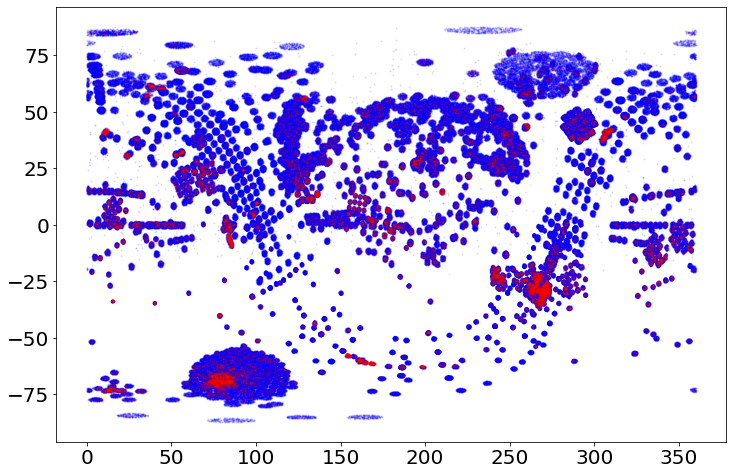

In [4]:
# TWO BITWISE FLAGS FOR BAD DATA - THESE REMOVE IDENTIFIED BAD DATA            
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

# Make a Boolena Mask to remove bad data
gd = (np.bitwise_and(star['aspcapflag'], badbits) == 0) &\
     (np.bitwise_and(star['starflag'], suspectbits) == 0) 
bd = (np.bitwise_and(star['aspcapflag'], badbits) != 0) |\
     (np.bitwise_and(star['starflag'], suspectbits) != 0) 

good = np.where(gd)[0]
bad = np.where(bd)[0]

# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(star['RA'][good],star['DEC'][good],s=1,c='b',alpha=0.1)
ax.scatter(star['RA'][bad],star['DEC'][bad],s=1,c='r',alpha=0.1)


ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()

LINEAR: -0.074, 16.223
POLY2: 0.005, -1.877, 130.634
COSFIT: 72.947, 0.018, -0.452, -5.700


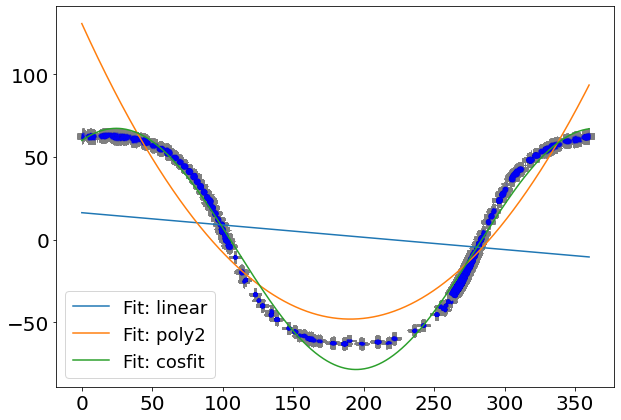

In [4]:
# EXAMPLE FIT - DR. FRINCHABOY
# --------------------------------------------
# First use Linear, Polnomial, and Cosine Fits
# Select stars only with with  −2 < GLAT < 2   
# 
# I FIT RA & DEC data versus LINEAR, POLY2, AND COSFIT in this example.  
#
# TWO BITWISE FLAGS TO REMOVE FOR OBVIOUSLY BAD DATA             
badbits = 2**23        # aspcapstar flag - Chemistry
suspectbits = 2**16    # star flag - Stellar parameters

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 2) &\
     (star['GLAT'] > -2) 
cut1 = np.where(ct1)[0]

#=================================================================================
## LINEAR FIT (2 parameter)
slope, intercept = mcFit2(linear, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                          0.001, p0=[0,0])
print(f'LINEAR: {slope:.3f}, {intercept:.3f}')

#=================================================================================
## POLY2 FIT (3 parameter)
polyA, polyB, polyC,  = mcFit3(poly2, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                         0.001,p0=[600,1,1])
print(f'POLY2: {polyA:.3f}, {polyB:.3f}, {polyC:.3f}')

#=================================================================================
## COS FIT (4 parameter)
cfA, cfB, cfC, cfD = mcFit4(cosfit, star['RA'][cut1], star['DEC'][cut1], 0.001, \
                            0.001,p0=[60,0.02,0,0])
print(f'COSFIT: {cfA:.3f}, {cfB:.3f}, {cfC:.3f}, {cfD:.3f}')
#=================================================================================



# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)

# PLOT DATA AND ERROR BARS
ax1.scatter(star['RA'][cut1],star['DEC'][cut1],s=1,c='b',alpha=0.1)
ax1.errorbar((star['RA'][cut1]),star['DEC'][cut1], xerr=(0.001),
             yerr=(0.001), ecolor='grey',fmt='none', capsize=5, zorder=0)


#=================================================================================
# PLOT DATA FITS FROM ABOVE
x_plot = np.linspace(0,360,1000) # X-PLOTING FOR FITS

#=================================================================================
#linear fit
ax1.plot(x_plot,linear(x_plot, slope, intercept), label='Fit: linear')
#poly2 fit
ax1.plot(x_plot,poly2(x_plot, polyA, polyB, polyC), label='Fit: poly2')
#cosfit
ax1.plot(x_plot,cosfit(x_plot, cfA, cfB, cfC, cfD), label='Fit: cosfit')

plt.legend(loc='best', fontsize=18)
plt.show()

# Homework #12

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_24_HW12a.ipynb

## DATA FIT 1

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
1. Select stars only with with $ GLAT > 20$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters?

<font color='blue'>a = -0.07342421532301295 </font>

<font color='blue'>b = -0.3169502148625636 </font>

<font color='blue'>c = 0.048186461331529026 </font>

2. Which fucntion fits the data best?

<font color='blue'>The 2nd order polynomial fits the best. </font>

3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

<font color='blue'>No </font>


In [5]:
# Monte Carlo-version of 2 parameter Curve Fit that can use BOTH x and Y errors
def mcFit2(func, x, y, x_err=0.1, y_err=0.1, p0=[0,0]):
    slope = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsx = np.random.randn(len(y))
        weightsy = np.random.randn(len(y))
        y_adj = y + y_err*weightsy
        x_adj = x + x_err*weightsx 
        popt, pcov = opt.curve_fit(func, x_adj, y_adj, p0=p0)
        slope.append(popt[0])
        y_ints.append(popt[1])
    return (np.median(slope),np.median(y_ints))

In [127]:
#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct1 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > 20) & ~np.isnan(star['Fe_H']) & ~np.isnan(star['Fe_H_ERR']) & \
     ~np.isnan(star['O_FE']) & ~np.isnan(star['O_FE_ERR'])
cut1 = np.where(ct1)[0]

# Setting up graphing parameters so I don't have to wait.
x_FeH = star['Fe_H'][cut1]
y_OFe = star['O_FE'][cut1]
x_FeH_err = star['Fe_H_ERR'][cut1]
y_OFe_err = star['O_FE_ERR'][cut1]

In [128]:
linear_data1_m, linear_data1_b = mcFit2(linear, x_FeH, y_OFe, x_err=x_FeH_err, y_err=y_OFe_err, p0=[0,0])

poly_data1_a, poly_data1_b, poly_data1_c = mcFit3(poly2, x_FeH, y_OFe, x_err=x_FeH_err, y_err=y_OFe_err, p0=[1,1,1])

poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d = mcFit4(poly3, x_FeH, y_OFe, x_err=x_FeH_err, y_err=y_OFe_err, p0=[1,1,1,1])

print(poly_data1_a, poly_data1_b, poly_data1_c)

-0.07342421532301295 -0.3169502148625636 0.048186461331529026


<ErrorbarContainer object of 3 artists>

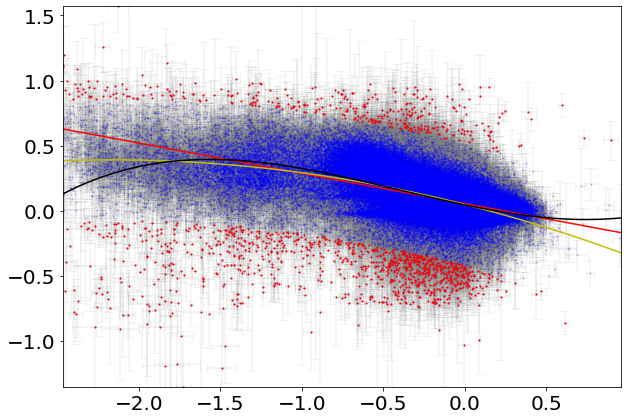

In [8]:
# write your fitting code, from part 1, and plot the results here
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_xlim(min(x_FeH),max(x_FeH))
ax1.set_ylim(min(y_OFe),max(y_OFe))

# Looking for outliers
outlier_mask = (abs(poly_data1_a*x_FeH**2+poly_data1_b*x_FeH+poly_data1_c - y_OFe) > 3*np.std(y_OFe))

fits_x = np.linspace(min(x_FeH),max(x_FeH),1000)
fits_y_linear = linear_data1_m*fits_x+linear_data1_b
fits_y_poly2 = poly_data1_a*fits_x**2+poly_data1_b*fits_x+poly_data1_c
fits_y_poly3 = poly3_data1_a*fits_x**3+ poly3_data1_b*fits_x**2+ poly3_data1_c*fits_x+ poly3_data1_d



# PLOT DATA AND ERROR BARS
ax1.plot(fits_x,fits_y_linear,c="r")
ax1.plot(fits_x,fits_y_poly2,c="y")
ax1.plot(fits_x,fits_y_poly3,c="k")
ax1.scatter(x_FeH,y_OFe,s=1,c='b',alpha=0.2)
# ax1.scatter(x_FeH,poly_data1_a*x_FeH**2+poly_data1_b*x_FeH+poly_data1_c,c='r')

ax1.scatter(x_FeH[outlier_mask],y_OFe[outlier_mask],s=1,c='r')

ax1.errorbar(x_FeH,y_OFe, xerr=(x_FeH_err),
             yerr=(y_OFe_err), ecolor='grey',fmt='none', capsize=5, zorder=0, alpha=0.1)

## DATA FIT 2

Fit a linear, polynomial (poly2), and a polynomial (poly3) functions and to the following selections of the data:
2. Select stars only with with $-1< GLAT < 1$ <br>
   __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  O\_FE (O\_FE\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 

<font color='blue'>a = 0.08845144533263838 </font>

<font color='blue'>b = 0.12806496210072782 </font>

<font color='blue'>c = -0.13054401311456887 </font>

<font color='blue'>d = 0.03296146302958586 </font>

2. Which fucntion fits the data best?

<font color='blue'>The 3rd order polynomial fits best. </font>

3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

<font color='blue'>It looks like there might be, but it is very close to the line of best fit and could potentially be noise. </font>


In [130]:
# write your fitting code, from part 1, and plot the results here

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct2 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] < 1) & (star['GLAT'] > -1) & ~np.isnan(star['Fe_H']) & ~np.isnan(star['Fe_H_ERR']) & \
     ~np.isnan(star['O_FE']) & ~np.isnan(star['O_FE_ERR'])
cut2 = np.where(ct2)[0]

# Setting up graphing parameters so I don't have to wait.
x_FeH = star['Fe_H'][cut2]
y_OFe = star['O_FE'][cut2]
x_FeH_err = star['Fe_H_ERR'][cut2]
y_OFe_err = star['O_FE_ERR'][cut2]

In [131]:
linear_data1_m, linear_data1_b = mcFit2(linear, x_FeH, y_OFe, x_err=x_FeH_err, y_err=y_OFe_err, p0=[0,0])

poly_data1_a, poly_data1_b, poly_data1_c = mcFit3(poly2, x_FeH, y_OFe, x_err=x_FeH_err, y_err=y_OFe_err, p0=[1,1,1])

poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d = mcFit4(poly3, x_FeH, y_OFe, x_err=x_FeH_err, y_err=y_OFe_err, p0=[1,1,1,1])

print(poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d)

0.08845144533263838 0.12806496210072782 -0.13054401311456887 0.03296146302958586


<ErrorbarContainer object of 3 artists>

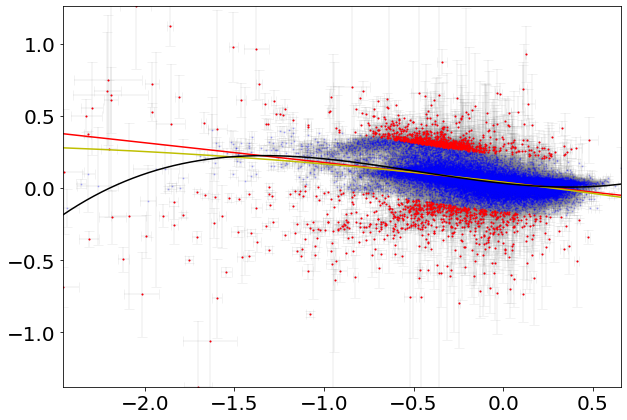

In [133]:
# write your fitting code, from part 1, and plot the results here
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_xlim(min(x_FeH),max(x_FeH))
ax1.set_ylim(min(y_OFe),max(y_OFe))

# Looking for outliers
outlier_mask = (abs(poly3_data1_a*x_FeH**3+ poly3_data1_b*x_FeH**2+ poly3_data1_c*x_FeH+ poly3_data1_d - y_OFe) > 2*np.std(y_OFe))

fits_x = np.linspace(min(x_FeH),max(x_FeH),1000)
fits_y_linear = linear_data1_m*fits_x+linear_data1_b
fits_y_poly2 = poly_data1_a*fits_x**2+poly_data1_b*fits_x+poly_data1_c
fits_y_poly3 = poly3_data1_a*fits_x**3+ poly3_data1_b*fits_x**2+ poly3_data1_c*fits_x+ poly3_data1_d



# PLOT DATA AND ERROR BARS
ax1.plot(fits_x,fits_y_linear,c="r")
ax1.plot(fits_x,fits_y_poly2,c="y")
ax1.plot(fits_x,fits_y_poly3,c="k")
ax1.scatter(x_FeH,y_OFe,s=1,c='b',alpha=0.2)
# ax1.scatter(x_FeH,poly_data1_a*x_FeH**2+poly_data1_b*x_FeH+poly_data1_c,c='r')

# Plotting Outliers
ax1.scatter(x_FeH[outlier_mask],y_OFe[outlier_mask],s=1,c='r')

ax1.errorbar(x_FeH,y_OFe, xerr=(x_FeH_err),
             yerr=(y_OFe_err), ecolor='grey',fmt='none', capsize=5, zorder=0, alpha=0.1)

In [124]:
print(poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d)

-0.02105993997652733 -0.01847187278292275 0.02605480281880821 0.01826151032568988


## DATA FIT 3

Fit a linear, polynomial (poly3), and a exponetial functions and to the following selections of the data:
3. Select stars only with with $340 < GLON < 360$ <br>
   __Fit TEFF,  (TEFF\_ERR)  vs.  LOGG (LOGG\_ERR)__<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 

<font color='blue'>a = 4.47120396476115e-12 </font>

<font color='blue'>b = -1.7390336475710993e-07 </font>

<font color='blue'>c = 0.002124804426299591 </font>

<font color='blue'>d = -4.025917412612013 </font>

2. Which fucntion fits the data best?

<font color='blue'> The 3rd order polynomial fits the best. </font>

3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

<font color='blue'> There are 2 possible second populations, but both are close enough to the line of best fit to be unable to really distingush from noise. </font>


In [134]:
# write your fitting cod# write your fitting code, from part 1, and plot the results here

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct3 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLON'] < 360) & (star['GLON'] > 340) & ~np.isnan(star['TEFF']) & ~np.isnan(star['TEFF_ERR']) & \
     ~np.isnan(star['LOGG']) & ~np.isnan(star['LOGG_ERR'])
cut3 = np.where(ct3)[0]

# Setting up graphing parameters so I don't have to wait.
x_teff = star['TEFF'][cut3]
y_logg = star['LOGG'][cut3]
x_teff_err = star['TEFF_ERR'][cut3]
y_logg_err = star['LOGG_ERR'][cut3]

In [135]:
x_tester = []
y_tester = []
x_err_tester = []
y_err_tester = []
count = 0
for i in range(len(x_teff)):
    if i%5 == 0:
        x_tester.append(x_teff[i])
        y_tester.append(y_logg[i])
        x_err_tester.append(x_teff_err[i])
        y_err_tester.append(y_logg_err[i])

dd = 1
aa = 1
        
bb = np.log((y_tester[0]-dd)/(y_tester[1]-dd))*(1/x_tester[0]-x_tester[1])**(-1) 
cc = np.log((y_tester[0]-dd)/aa)-bb*x_tester[0]
      
print(bb,cc)
        
testa, testb, testc, testd = mcFit4(exponential, x_tester, y_tester, x_err=x_err_tester, y_err=y_err_tester, p0=[aa,bb,cc,dd])

-0.0001358363421834886 1.9715669950357246


C:\Users\saxon\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [136]:
# def exponential(x,a,b,c,d):
    # return a*np.exp(b*x + c) + d

linear_data1_m, linear_data1_b = mcFit2(linear, x_teff, y_logg, x_err=x_teff_err, y_err=y_logg_err, p0=[0,0])

# poly_data1_a, poly_data1_b, poly_data1_c = mcFit3(poly2, x_FeH, y_OFe, x_err=x_FeH_err, y_err=y_OFe_err, p0=[1,1,1])

poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d = mcFit4(poly3, x_teff, y_logg, x_err=x_teff_err, y_err=y_logg_err, p0=[1,1,1,1])


exp_data_a, exp_data_b, exp_data_c, exp_data_d = mcFit4(exponential, x_teff, y_logg, x_err=x_teff_err, y_err=y_logg_err, p0=[aa,bb,cc,dd])

print(poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d)

4.47120396476115e-12 -1.7390336475710993e-07 0.002124804426299591 -4.025917412612013


<ErrorbarContainer object of 3 artists>

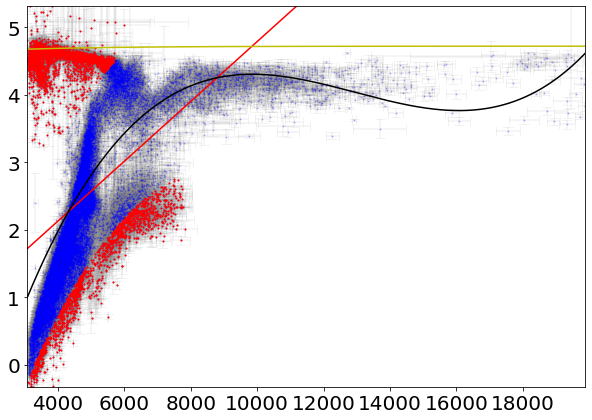

In [137]:
# write your fitting code, from part 1, and plot the results here
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_xlim(min(x_teff),max(x_teff))
ax1.set_ylim(min(y_logg),max(y_logg))

# Looking for outliers
outlier_mask = (abs(poly3_data1_a*x_teff**3+ poly3_data1_b*x_teff**2+ poly3_data1_c*x_teff+ poly3_data1_d - y_logg) > 1*np.std(y_logg))

fits_x = np.linspace(min(x_teff),max(x_teff),1000)
fits_y_linear = linear_data1_m*fits_x+linear_data1_b
# fits_y_poly2 = poly_data1_a*fits_x**2+poly_data1_b*fits_x+poly_data1_c
fits_y_poly3 = poly3_data1_a*fits_x**3+ poly3_data1_b*fits_x**2+ poly3_data1_c*fits_x+ poly3_data1_d
fits_y_exp = exp_data_a*np.exp(exp_data_b*fits_x-exp_data_c)+exp_data_d


# PLOT DATA AND ERROR BARS
ax1.plot(fits_x,fits_y_linear,c="r")
# ax1.plot(fits_x,fits_y_poly2,c="y")
ax1.plot(fits_x,fits_y_poly3,c="k")
ax1.plot(fits_x,fits_y_exp,c="y")
ax1.scatter(x_teff,y_logg,s=1,c='b',alpha=0.2)
# ax1.scatter(x_FeH,poly_data1_a*x_FeH**2+poly_data1_b*x_FeH+poly_data1_c,c='r')

# Plotting Outliers
ax1.scatter(x_teff[outlier_mask],y_logg[outlier_mask],s=1,c='r')

ax1.errorbar(x_teff,y_logg, xerr=(x_teff_err),
             yerr=(y_logg_err), ecolor='grey',fmt='none', capsize=5, zorder=0, alpha=0.1)

## DATA FIT 4

Fit  a linear, a exponential, and a polynomial (poly2) functions and to the following selections of the data:
4. Select stars only with with $DEC < -50$ and $50 < RA < 120$ <br>
   __Fit TEFF,  (TEFF\_ERR)   vs.  (star['J'] - star['K']) (JK_ERR)__<br>
<br>
<b>NOTE: you will have to create a (J-K) error:</b>  JK_ERR = np.sqrt( J\_ERR^2 + K\_ERR^2 )<br> 

For this fit of the above selection:

1. What are the best-fit values of the parameters?

<font color='blue'>a = -4.1678431726164685e-13 </font>

<font color='blue'>b = 4.631486486080093e-08 </font>

<font color='blue'>c = -0.0007645563164663271 </font>

<font color='blue'>d = 3.321689874240853 </font>

2. Which fucntion fits the data best?

<font color='blue'>The 3rd order polynomial fits the best. </font>

3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

<font color='blue'>No. </font>


In [138]:
# write your fitting cod# write your fitting code, from part 1, and plot the results here

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct4 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['DEC'] < -50) & (star['RA'] > -50) & (star['RA'] < 50) & ~np.isnan(star['TEFF']) & ~np.isnan(star['TEFF_ERR']) & \
     ~np.isnan(star['J']) & ~np.isnan(star['K']) & ~np.isnan(star['J_ERR']) & ~np.isnan(star['K_ERR'])
cut4 = np.where(ct4)[0]

# Setting up graphing parameters so I don't have to wait.
x_teff = star['TEFF'][cut4]
y_jk = star['J'][cut4] - star['K'][cut4]
x_teff_err = star['TEFF_ERR'][cut4]
y_jk_err = np.sqrt(star['J_ERR'][cut4]**2 + star['K_ERR'][cut4]**2)

In [139]:
x_tester = []
y_tester = []
x_err_tester = []
y_err_tester = []
count = 0
for i in range(len(x_teff)):
    if i%5 == 0:
        x_tester.append(x_teff[i])
        y_tester.append(y_jk[i])
        x_err_tester.append(x_teff_err[i])
        y_err_tester.append(y_jk_err[i])        
        
dd = 0.5
aa = 1
        
bb = np.log((y_tester[0]-dd)/(y_tester[1]-dd))*(1/x_tester[0]-x_tester[1])**(-1) 
cc = np.log((y_tester[0]-dd)/aa)-bb*x_tester[0]
      
print(y_tester[0], y_tester[1], bb, cc)
        
testa, testb, testc, testd = mcFit4(exponential, x_tester, y_tester, x_err=x_err_tester, y_err=y_err_tester, p0=[aa,bb,cc,dd])
print(testa, testb, testc, testd)

0.73099995 0.8100004 6.502696727951997e-05 -1.761201388110135
3.2545417264215564 -0.00036881299813984643 0.46508061404410805 -0.22961311063646297


In [140]:
# def exponential(x,a,b,c,d):
    # return a*np.exp(b*x + c) + d

linear_data1_m, linear_data1_b = mcFit2(linear, x_teff, y_jk, x_err=x_teff_err, y_err=y_jk_err, p0=[0,0])

# poly_data1_a, poly_data1_b, poly_data1_c = mcFit3(poly2, x_FeH, y_OFe, x_err=x_FeH_err, y_err=y_OFe_err, p0=[1,1,1])

poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d = mcFit4(poly3, x_teff, y_jk, x_err=x_teff_err, y_err=y_jk_err, p0=[1,1,1,1])

exp_data_a, exp_data_b, exp_data_c, exp_data_d = mcFit4(exponential, x_teff, y_jk, x_err=x_teff_err, y_err=y_jk_err, p0=[testa,testb,testc,testd])

print(poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d)

-4.1678431726164685e-13 4.631486486080093e-08 -0.0007645563164663271 3.321689874240853


<ErrorbarContainer object of 3 artists>

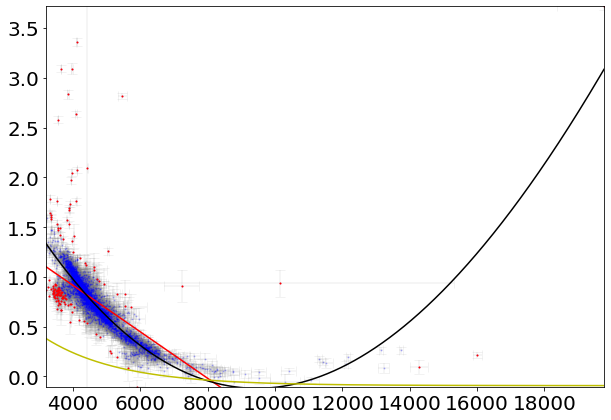

In [142]:
# write your fitting code, from part 1, and plot the results here
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_xlim(min(x_teff),max(x_teff))
ax1.set_ylim(min(y_jk),max(y_jk))

# Looking for outliers
outlier_mask = (abs(poly3_data1_a*x_teff**3+ poly3_data1_b*x_teff**2+ poly3_data1_c*x_teff+ poly3_data1_d - y_jk) > 1*np.std(y_jk))

fits_x = np.linspace(min(x_teff),max(x_teff),1000)
fits_y_linear = linear_data1_m*fits_x+linear_data1_b
# fits_y_poly2 = poly_data1_a*fits_x**2+poly_data1_b*fits_x+poly_data1_c
fits_y_poly3 = poly3_data1_a*fits_x**3+ poly3_data1_b*fits_x**2+ poly3_data1_c*fits_x+ poly3_data1_d
fits_y_exp = exp_data_a*np.exp(exp_data_b*fits_x-exp_data_c)+exp_data_d


# PLOT DATA AND ERROR BARS
ax1.plot(fits_x,fits_y_linear,c="r")
# ax1.plot(fits_x,fits_y_poly2,c="y")
ax1.plot(fits_x,fits_y_poly3,c="k")
ax1.plot(fits_x,fits_y_exp,c="y")
ax1.scatter(x_teff,y_jk,s=1,c='b',alpha=0.2)
# ax1.scatter(x_FeH,poly_data1_a*x_FeH**2+poly_data1_b*x_FeH+poly_data1_c,c='r')

# Plotting Outliers
ax1.scatter(x_teff[outlier_mask],y_jk[outlier_mask],s=1,c='r')

ax1.errorbar(x_teff,y_jk, xerr=(x_teff_err),
             yerr=(y_jk_err), ecolor='grey',fmt='none', capsize=5, zorder=0, alpha=0.1)

## DATA FIT 5

Fit  a linear, a polynomial (poly3), and a cosfit functions and to the following selections of the data:
5. Select stars only with with $-10< GLAT < 10$<br>
   __Fit GLON (0.0001) vs.  VHEILO\_AVG (VERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters?

<font color='blue'>a = -2.7599561986005835e-05 </font>

<font color='blue'>b = 0.014251879958627846 </font>

<font color='blue'>c = -1.7807876598547971 </font>

<font color='blue'>d = 27.97086764243765 </font>

2. Which fucntion fits the data best?

<font color='blue'>The 3rd order polynomial fits best. </font>

3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

<font color='blue'>No. </font>


In [143]:
# write your fitting cod# write your fitting code, from part 1, and plot the results here

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct5 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     (star['GLAT'] > -10) & (star['GLAT'] < 10) & ~np.isnan(star['GLON']) & \
     ~np.isnan(star['VHELIO_AVG']) & ~np.isnan(star['VERR'])
cut5 = np.where(ct5)[0]

# Setting up graphing parameters so I don't have to wait.
x_glon = star['GLON'][cut5]
y_vhelio = star['VHELIO_AVG'][cut5]
x_glon_err = 0.0001
y_v_err = star['VERR'][cut5]

In [112]:
x_tester = []
y_tester = []
x_err_tester = []
y_err_tester = []
count = 0
for i in range(len(x_glon)):
    if i%5 == 0:
        x_tester.append(x_glon[i])
        y_tester.append(y_vhelio[i])
        # x_err_tester.append(x_glon_err[i])
        y_err_tester.append(y_v_err[i])        
        
dd = 0.5
aa = 1
        
bb = np.log((y_tester[0]-dd)/(y_tester[1]-dd))*(1/x_tester[0]-x_tester[1])**(-1) 
cc = np.log((y_tester[0]-dd)/aa)-bb*x_tester[0]
      
print(y_tester[0], y_tester[1], bb, cc)
        
testa, testb, testc, testd = mcFit4(cosfit, x_tester, y_tester, x_err=0.0001, y_err=y_err_tester, p0=[50,55.7,0,0])
print(testa, testb, testc, testd)

C:\Users\saxon\AppData\Local\Temp\ipykernel_23340\3106860997.py:17: RuntimeWarning: invalid value encountered in log
  cc = np.log((y_tester[0]-dd)/aa)-bb*x_tester[0]


-20.545164 -43.84838 0.006435734046681876 nan
-1.3068888373235494 55.71366123006902 -3.717069402010222 -4.339096503727026


In [144]:
# def exponential(x,a,b,c,d):
    # return a*np.exp(b*x + c) + d

# linear_data1_m, linear_data1_b = mcFit2(linear, x_glon, y_vhelio, x_err=x_glon_err, y_err=y_v_err, p0=[0,0])

# # poly_data1_a, poly_data1_b, poly_data1_c = mcFit3(poly2, x_FeH, y_OFe, x_err=x_FeH_err, y_err=y_OFe_err, p0=[1,1,1])

poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d = mcFit4(poly3, x_glon, y_vhelio, x_err=x_glon_err, y_err=y_v_err, p0=[1,1,1,1])

# exp_data_a, exp_data_b, exp_data_c, exp_data_d = mcFit4(exponential, x_teff, y_jk, x_err=x_teff_err, y_err=y_jk_err, p0=[aa,bb,cc,dd])

# cos_data_a, cos_data_b, cos_data_c, cos_data_d = mcFit4(cosfit, x_glon, y_vhelio, x_err=x_glon_err, y_err=y_v_err, p0=[testa, testb, testc, testd])

print(poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d)

-2.7599561986005835e-05 0.014251879958627846 -1.7807876598547971 27.97086764243765


<ErrorbarContainer object of 3 artists>

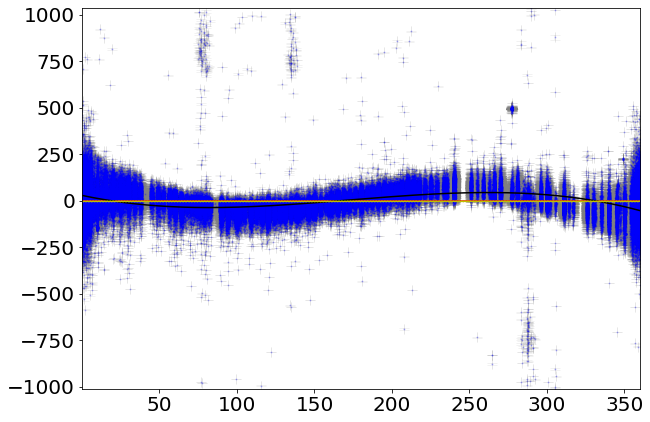

In [113]:
# write your fitting code, from part 1, and plot the results here
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_xlim(min(x_glon),max(x_glon))
ax1.set_ylim(min(y_vhelio),max(y_vhelio))

# Looking for outliers
# outlier_mask = (abs(poly3_data1_a*x_teff**3+ poly3_data1_b*x_teff**2+ poly3_data1_c*x_teff+ poly3_data1_d - y_jk) > 1*np.std(y_jk))

fits_x = np.linspace(min(x_glon),max(x_glon),1000)
fits_y_linear = linear_data1_m*fits_x+linear_data1_b
# fits_y_poly2 = poly_data1_a*fits_x**2+poly_data1_b*fits_x+poly_data1_c
fits_y_poly3 = poly3_data1_a*fits_x**3+ poly3_data1_b*fits_x**2+ poly3_data1_c*fits_x+ poly3_data1_d
# fits_y_exp = exp_data_a*np.exp(exp_data_b*fits_x-exp_data_c)+exp_data_d
fits_y_cos = cos_data_a*np.cos(cos_data_b*fits_x-cos_data_c)+cos_data_d
fits_y_cos = testa*np.cos(testb*fits_x-testc)+testd



# PLOT DATA AND ERROR BARS
ax1.plot(fits_x,fits_y_linear,c="r")
# ax1.plot(fits_x,fits_y_poly2,c="y")
ax1.plot(fits_x,fits_y_poly3,c="k")
# ax1.plot(fits_x,fits_y_exp,c="y")
ax1.plot(fits_x,fits_y_cos,c="y")
ax1.scatter(x_glon,y_vhelio,s=1,c='b',alpha=0.2)
# ax1.scatter(x_FeH,poly_data1_a*x_FeH**2+poly_data1_b*x_FeH+poly_data1_c,c='r')

# Plotting Outliers
# ax1.scatter(x_teff[outlier_mask],y_jk[outlier_mask],s=1,c='r')

ax1.errorbar(x_glon,y_vhelio, xerr=(0.0001),
             yerr=(y_v_err), ecolor='grey',fmt='none', capsize=5, zorder=0, alpha=0.1)

## DATA FIT 6

Fit  a linear and a polynomial (poly2 AND poly3) functions and to the following selections of the data:
7. __Fit Fe\_H,  (Fe\_H\_ERR)  vs.  NI\_FE (NI\_FE\_ERR)__<br>
<br>

For this fit of the above selection:

1. What are the best-fit values of the parameters? 

<font color='blue'>a = 0.024377594331336398 </font>

<font color='blue'>b = 0.037613606008578104 </font>

<font color='blue'>c = 0.016736098058608165 </font>

2. Which fucntion fits the data best?

<font color='blue'>The 2nd order polynomial fits the best. </font>

3. Is there a second population? (Can you fit outliers with a reasonable linear trend?)

<font color='blue'>No. </font>


In [114]:
# write your fitting cod# write your fitting code, from part 1, and plot the results here

#=================================================================================
# Make a Boolena Mask to remove bad data - AND ANY OTHER NEEDED CUTS 
# (e.g., −2 < GLAT < 2 ) or other 'bad' data not removed by the flags.
ct6 = (np.bitwise_and(star['aspcapflag'], badbits) == 0) & \
     (np.bitwise_and(star['starflag'], suspectbits) == 0) & \
     ~np.isnan(star['Fe_H']) & \
     ~np.isnan(star['Fe_H_ERR']) & ~np.isnan(star['NI_Fe']) & ~np.isnan(star['NI_Fe_ERR'])
cut6 = np.where(ct6)[0]

# Setting up graphing parameters so I don't have to wait.
x_FeH = star['Fe_H'][cut6]
y_NIFE = star['NI_Fe'][cut6]
x_FeH_err = star['Fe_H_ERR'][cut6]
y_NIFe_err = star['NI_Fe_ERR'][cut6]

In [119]:
# def exponential(x,a,b,c,d):
    # return a*np.exp(b*x + c) + d

# linear_data1_m, linear_data1_b = mcFit2(linear, x_glon, y_vhelio, x_err=x_glon_err, y_err=y_v_err, p0=[0,0])

poly_data1_a, poly_data1_b, poly_data1_c = mcFit3(poly2, x_FeH, y_NIFE, x_err=x_FeH_err, y_err=y_NIFe_err, p0=[1,1,1])

poly3_data1_a, poly3_data1_b, poly3_data1_c, poly3_data1_d = mcFit4(poly3, x_FeH, y_NIFE, x_err=x_FeH_err, y_err=y_NIFe_err, p0=[1,1,1,1])

# exp_data_a, exp_data_b, exp_data_c, exp_data_d = mcFit4(exponential, x_teff, y_jk, x_err=x_teff_err, y_err=y_jk_err, p0=[aa,bb,cc,dd])

# cos_data_a, cos_data_b, cos_data_c, cos_data_d = mcFit4(cosfit, x_glon, y_vhelio, x_err=x_glon_err, y_err=y_v_err, p0=[testa, testb, testc, testd])

# print(exp_data_a, exp_data_b, exp_data_c, exp_data_d)

<ErrorbarContainer object of 3 artists>

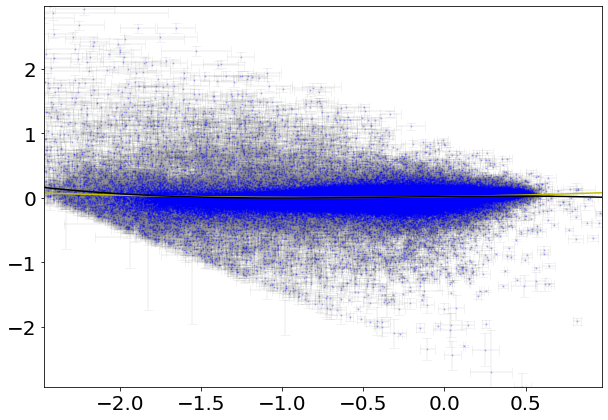

In [121]:
# write your fitting code, from part 1, and plot the results here
# PLOT TO VERIFY FITS FILE READ IN & BAD MASK DATA
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot(111)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax1.set_xlim(min(x_FeH),max(x_FeH))
ax1.set_ylim(min(y_NIFE),max(y_NIFE))

# Looking for outliers
# outlier_mask = (abs(poly3_data1_a*x_teff**3+ poly3_data1_b*x_teff**2+ poly3_data1_c*x_teff+ poly3_data1_d - y_jk) > 1*np.std(y_jk))

fits_x = np.linspace(min(x_FeH),max(x_FeH),1000)
# fits_y_linear = linear_data1_m*fits_x+linear_data1_b
fits_y_poly2 = poly_data1_a*fits_x**2+poly_data1_b*fits_x+poly_data1_c
fits_y_poly3 = poly3_data1_a*fits_x**3+ poly3_data1_b*fits_x**2+ poly3_data1_c*fits_x+ poly3_data1_d
# # fits_y_exp = exp_data_a*np.exp(exp_data_b*fits_x-exp_data_c)+exp_data_d
# fits_y_cos = cos_data_a*np.cos(cos_data_b*fits_x-cos_data_c)+cos_data_d
# fits_y_cos = testa*np.cos(testb*fits_x-testc)+testd



# PLOT DATA AND ERROR BARS
# ax1.plot(fits_x,fits_y_linear,c="r")
ax1.plot(fits_x,fits_y_poly2,c="y")
ax1.plot(fits_x,fits_y_poly3,c="k")
# # ax1.plot(fits_x,fits_y_exp,c="y")
# ax1.plot(fits_x,fits_y_cos,c="y")
ax1.scatter(x_FeH,y_NIFE,s=1,c='b',alpha=0.2)
# ax1.scatter(x_FeH,poly_data1_a*x_FeH**2+poly_data1_b*x_FeH+poly_data1_c,c='r')

# Plotting Outliers
# ax1.scatter(x_teff[outlier_mask],y_jk[outlier_mask],s=1,c='r')

ax1.errorbar(x_FeH,y_NIFE, xerr=(x_FeH_err),
             yerr=(y_NIFe_err), ecolor='grey',fmt='none', capsize=5, zorder=0, alpha=0.1)